In [1]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torchvision.datasets as dset
import torchvision.transforms as transforms
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision.models as models
import cv2
import sys
import math
import random
import splitfolders
import torchsummary
from ViT import vit
from tqdm.auto import tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score

In [2]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [3]:
CFG = {
    'IMG_SIZE':224,
    'EPOCHS':100,
    'LEARNING_RATE':3e-5,
    'BATCH_SIZE':12,
    'SEED':42
}

In [4]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(CFG['SEED'])

In [5]:
train_df = pd.read_csv('./train_data_action.csv')
test_df = pd.read_csv('./test_data_action.csv')

In [6]:
train_df['action'].value_counts()

work                     13458
travel                    5020
recreation_media          4886
meal                      4012
household                 2304
recreation_etc            2045
socialising               1922
outdoor_act               1717
personal_care             1254
sleep                      573
study                      465
hobby                      392
shop                       184
community_interaction       28
entertainment                6
Name: action, dtype: int64

In [7]:
test_df['action'].value_counts()

work                     3365
travel                   1255
recreation_media         1222
meal                     1003
household                 576
recreation_etc            511
socialising               480
outdoor_act               429
personal_care             314
sleep                     143
study                     116
hobby                      98
shop                       46
community_interaction       7
entertainment               2
Name: action, dtype: int64

In [8]:
le = LabelEncoder()
le = le.fit(train_df['action'])
train_df['action'] = le.transform(train_df['action'])
test_df['action'] = le.transform(test_df['action'])

In [9]:
train_df[train_df['action']==14]

,Unnamed: 0,ts,action,img_path
0,23440,1.600663e+09,14,./train/data/user03/1600635600/RP/1600662780.png
1,39052,1.600233e+09,14,./train/data/user04/1600207800/RP/1600233000.png
4,15779,1.599108e+09,14,./train/data/user03/1599058980/RP/1599108300.png
6,29029,1.598920e+09,14,./train/data/user04/1598912400/RP/1598919840.png
13,12951,1.600820e+09,14,./train/data/user02/1600786800/RP/1600819860.png
...,...,...,...,...
38258,47512,1.601186e+09,14,./train/data/user04/1601163000/RP/1601185980.png
38259,42817,1.600666e+09,14,./train/data/user04/1600640400/RP/1600665660.png
38261,36655,1.599880e+09,14,./train/data/user04/1599859800/RP/1599880440.png
38262,10357,1.599116e+09,14,./train/data/user02/1599058800/RP/1599116160.png


In [10]:
path_list = train_df[train_df['action']==14]['img_path']
pl = list(path_list)

In [11]:
tmp = random.sample(pl, 500)

In [12]:
tmp

['./train/data/user04/1600035000/RP/1600056840.png',
 './train/data/user04/1600294800/RP/1600328820.png',
 './train/data/user04/1599690000/RP/1599701640.png',
 './train/data/user04/1600899900/RP/1600908360.png',
 './train/data/user04/1600207800/RP/1600223100.png',
 './train/data/user02/1600700400/RP/1600758660.png',
 './train/data/user04/1600726800/RP/1600754940.png',
 './train/data/user04/1599690000/RP/1599717300.png',
 './train/data/user01/1600315920/RP/1600328040.png',
 './train/data/user04/1600558200/RP/1600574220.png',
 './train/data/user02/1598972400/RP/1599041520.png',
 './train/data/user04/1599522960/RP/1599523260.png',
 './train/data/user01/1600450920/RP/1600498740.png',
 './train/data/user04/1600640400/RP/1600667460.png',
 './train/data/user02/1600961640/RP/1601007660.png',
 './train/data/user03/1600707600/RP/1600737660.png',
 './train/data/user02/1599922800/RP/1599992940.png',
 './train/data/user04/1599430860/RP/1599460560.png',
 './train/data/user02/1598886000/RP/1598922300

In [13]:
img_path_list = []

In [14]:
for i in range(15):
    path_list = list(train_df[train_df['action']==i]['img_path'])
    if len(path_list) >= 500:
        tmp = random.sample(path_list, 500)
        for i in tmp:
            img_path_list.append(i)
    else:
        for i in path_list:
            img_path_list.append(i)

In [15]:
df = pd.DataFrame(img_path_list)
df.columns = ['img_path']
df

,img_path
0,./train/data/user01/1601166300/RP/1601173320.png
1,./train/data/user01/1601166300/RP/1601172960.png
2,./train/data/user01/1601166300/RP/1601173140.png
3,./train/data/user01/1601166300/RP/1601173560.png
4,./train/data/user01/1601166300/RP/1601173620.png
...,...
6070,./train/data/user03/1600792200/RP/1600841280.png
6071,./train/data/user04/1600207800/RP/1600218600.png
6072,./train/data/user04/1599522960/RP/1599552060.png
6073,./train/data/user03/1598886300/RP/1598941020.png


In [16]:
path_label_df = pd.merge(train_df, df, on='img_path', how='inner')
path_label_df

,Unnamed: 0,ts,action,img_path
0,35,1.598878e+09,12,./train/data/user01/1598832660/RP/1598878440.png
1,7447,1.601106e+09,10,./train/data/user01/1601085900/RP/1601105520.png
2,10644,1.599904e+09,10,./train/data/user02/1599893100/RP/1599903840.png
3,34985,1.599693e+09,13,./train/data/user04/1599690000/RP/1599692940.png
4,9987,1.599104e+09,4,./train/data/user02/1599058800/RP/1599103620.png
...,...,...,...,...
6070,6479,1.600865e+09,12,./train/data/user01/1600831800/RP/1600864620.png
6071,13877,1.601099e+09,6,./train/data/user02/1601046000/RP/1601098980.png
6072,16350,1.599290e+09,3,./train/data/user03/1599231660/RP/1599289560.png
6073,39489,1.600260e+09,5,./train/data/user04/1600207800/RP/1600259700.png


In [17]:
path_label_df['action'].value_counts()

10    500
13    500
4     500
11    500
3     500
6     500
14    500
7     500
5     500
8     500
12    465
2     392
9     184
0      28
1       6
Name: action, dtype: int64

In [18]:
train, val, _, _ = train_test_split(path_label_df, path_label_df['action'], test_size=0.1, random_state=CFG['SEED'])

In [19]:
tfms = A.Compose([
    A.Resize(width=CFG['IMG_SIZE'], height=CFG['IMG_SIZE']),
    A.Normalize()
], p=1)

In [20]:
class CustomDataset(Dataset):
    def __init__(self, df, rp_path_list, label_list, tfms=None):
        super().__init__()
        self.df = df
        self.rp_path_list = rp_path_list
        self.label_list = label_list
        self.tfms=tfms
    
    def __len__(self):
        return len(self.rp_path_list)
    
    def __getitem__(self, idx):
        img = cv2.imread(self.rp_path_list[idx])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        image = self.tfms(image=img)['image']
        image = torch.tensor(np.array(image)).permute(2, 0, 1)
        
        if self.label_list is not None:
            label = self.label_list[idx]
            return image, label
        else:
            return image

In [21]:
train_dataset = CustomDataset(df=train, rp_path_list=train['img_path'].values, label_list=train['action'].values, tfms=tfms)
train_loader = DataLoader(train_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=True, num_workers=0)

val_dataset = CustomDataset(df=val,rp_path_list=val['img_path'].values, label_list=val['action'].values, tfms=tfms)
val_loader = DataLoader(val_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=False, num_workers=0)

In [22]:
class FocalLoss(nn.Module):
    def __init__(self, weight=None, gamma=2, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.weight = weight
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, weight=self.weight, reduction=self.reduction)
        pt = torch.exp(-ce_loss)
        focal_loss = ((1-pt)**self.gamma * ce_loss).mean()
        return focal_loss

In [23]:
def train(model, optimizer, train_loader, val_loader, scheduler, device):
    model.to(device)
    criterion = FocalLoss().to(device)
    
    best_val_score = 0
    best_model = None
    
    for epoch in range(1, CFG['EPOCHS']+1):
        model.train()
        train_loss = []
        for images, labels in tqdm(iter(train_loader)):
            images = images.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            
            output = model(images)
            loss = criterion(output, labels)
            
            loss.backward()
            optimizer.step()
            
            train_loss.append(loss.item())
                    
        _val_loss, _val_score = validation(model, criterion, val_loader, device)
        _train_loss = np.mean(train_loss)
        print(f'Epoch [{epoch}], Train Loss : [{_train_loss:.5f}] Val Loss : [{_val_loss:.5f}] Val F1 : [{_val_score:.5f}]')
        
        if scheduler is not None:
            scheduler.step(_val_score)
            
        if best_val_score < _val_score:
            best_val_score = _val_score
            best_model = model
    
    return best_model

In [24]:
def validation(model, criterion, val_loader, device):
    model.eval()
    val_loss = []
    preds, trues = [], []
    
    with torch.no_grad():
        for images, labels in tqdm(iter(val_loader)):
            images = images.to(device)
            labels = labels.to(device)
            
            logit = model(images)
            
            loss = criterion(logit, labels)
            
            val_loss.append(loss.item())
            
            preds += logit.argmax(1).detach().cpu().numpy().tolist()
            trues += labels.detach().cpu().numpy().tolist()
        
        _val_loss = np.mean(val_loss)
    
    _val_score = f1_score(trues, preds, average='micro')
    return _val_loss, _val_score

In [25]:
model = vit.ViT(n_classes = 15)
model.eval()
optimizer = torch.optim.Adam(params = model.parameters(), lr = CFG["LEARNING_RATE"])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2,threshold_mode='abs',min_lr=1e-8, verbose=True)

infer_model = train(model, optimizer, train_loader, val_loader, scheduler, device)

  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch [1], Train Loss : [2.21677] Val Loss : [2.16966] Val F1 : [0.11513]


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch [2], Train Loss : [2.09416] Val Loss : [2.06123] Val F1 : [0.15461]


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch [3], Train Loss : [2.03929] Val Loss : [2.09293] Val F1 : [0.12829]


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch [4], Train Loss : [2.01349] Val Loss : [2.02443] Val F1 : [0.15789]


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch [5], Train Loss : [1.98959] Val Loss : [2.02291] Val F1 : [0.18092]


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch [6], Train Loss : [1.96863] Val Loss : [2.04887] Val F1 : [0.14309]


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch [7], Train Loss : [1.95782] Val Loss : [2.01239] Val F1 : [0.15789]


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch [8], Train Loss : [1.94830] Val Loss : [2.03041] Val F1 : [0.16776]
Epoch 00008: reducing learning rate of group 0 to 1.5000e-05.


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch [9], Train Loss : [1.89652] Val Loss : [1.98255] Val F1 : [0.20066]


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch [10], Train Loss : [1.88211] Val Loss : [1.98336] Val F1 : [0.21053]


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch [11], Train Loss : [1.87349] Val Loss : [2.00927] Val F1 : [0.18421]


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch [12], Train Loss : [1.85585] Val Loss : [1.95331] Val F1 : [0.19901]


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch [13], Train Loss : [1.84893] Val Loss : [1.96588] Val F1 : [0.21217]


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch [14], Train Loss : [1.83490] Val Loss : [1.94895] Val F1 : [0.20230]


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch [15], Train Loss : [1.82334] Val Loss : [1.96513] Val F1 : [0.18421]


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch [16], Train Loss : [1.81425] Val Loss : [1.94903] Val F1 : [0.20395]
Epoch 00016: reducing learning rate of group 0 to 7.5000e-06.


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch [17], Train Loss : [1.77192] Val Loss : [1.94916] Val F1 : [0.21382]


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch [18], Train Loss : [1.75465] Val Loss : [1.95768] Val F1 : [0.21053]


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch [19], Train Loss : [1.74076] Val Loss : [1.94420] Val F1 : [0.21546]


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch [20], Train Loss : [1.72486] Val Loss : [1.95128] Val F1 : [0.21875]


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch [21], Train Loss : [1.71605] Val Loss : [1.96761] Val F1 : [0.21053]


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch [22], Train Loss : [1.69877] Val Loss : [1.96471] Val F1 : [0.21875]


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch [23], Train Loss : [1.68421] Val Loss : [1.97776] Val F1 : [0.22204]


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch [24], Train Loss : [1.66829] Val Loss : [1.97316] Val F1 : [0.23026]


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch [25], Train Loss : [1.64738] Val Loss : [1.96626] Val F1 : [0.22039]


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch [26], Train Loss : [1.63499] Val Loss : [1.98349] Val F1 : [0.22204]


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch [27], Train Loss : [1.61666] Val Loss : [2.00297] Val F1 : [0.21875]
Epoch 00027: reducing learning rate of group 0 to 3.7500e-06.


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch [28], Train Loss : [1.56272] Val Loss : [2.01320] Val F1 : [0.23355]


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch [29], Train Loss : [1.53646] Val Loss : [2.01122] Val F1 : [0.22368]


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch [30], Train Loss : [1.51691] Val Loss : [2.05074] Val F1 : [0.22039]


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch [31], Train Loss : [1.49888] Val Loss : [2.06253] Val F1 : [0.22368]
Epoch 00031: reducing learning rate of group 0 to 1.8750e-06.


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch [32], Train Loss : [1.45509] Val Loss : [2.06591] Val F1 : [0.21546]


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch [33], Train Loss : [1.43361] Val Loss : [2.09063] Val F1 : [0.23026]


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch [34], Train Loss : [1.41854] Val Loss : [2.10694] Val F1 : [0.22862]
Epoch 00034: reducing learning rate of group 0 to 9.3750e-07.


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch [35], Train Loss : [1.38756] Val Loss : [2.12650] Val F1 : [0.21382]


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch [36], Train Loss : [1.37586] Val Loss : [2.13211] Val F1 : [0.22039]


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch [37], Train Loss : [1.36788] Val Loss : [2.14032] Val F1 : [0.21875]
Epoch 00037: reducing learning rate of group 0 to 4.6875e-07.


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch [38], Train Loss : [1.34967] Val Loss : [2.15724] Val F1 : [0.21217]


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch [39], Train Loss : [1.34519] Val Loss : [2.16047] Val F1 : [0.23191]


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch [40], Train Loss : [1.33886] Val Loss : [2.17188] Val F1 : [0.22039]
Epoch 00040: reducing learning rate of group 0 to 2.3438e-07.


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch [41], Train Loss : [1.32888] Val Loss : [2.17091] Val F1 : [0.21217]


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch [42], Train Loss : [1.32673] Val Loss : [2.16852] Val F1 : [0.21711]


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch [43], Train Loss : [1.32302] Val Loss : [2.17633] Val F1 : [0.21217]
Epoch 00043: reducing learning rate of group 0 to 1.1719e-07.


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch [44], Train Loss : [1.31884] Val Loss : [2.17776] Val F1 : [0.21382]


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch [45], Train Loss : [1.31773] Val Loss : [2.18148] Val F1 : [0.20888]


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch [46], Train Loss : [1.31677] Val Loss : [2.18261] Val F1 : [0.20888]
Epoch 00046: reducing learning rate of group 0 to 5.8594e-08.


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch [47], Train Loss : [1.31324] Val Loss : [2.18246] Val F1 : [0.21053]


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch [48], Train Loss : [1.31389] Val Loss : [2.18366] Val F1 : [0.21382]


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch [49], Train Loss : [1.31218] Val Loss : [2.18577] Val F1 : [0.20888]
Epoch 00049: reducing learning rate of group 0 to 2.9297e-08.


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch [50], Train Loss : [1.31116] Val Loss : [2.18566] Val F1 : [0.21053]


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch [51], Train Loss : [1.31174] Val Loss : [2.18612] Val F1 : [0.21053]


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch [52], Train Loss : [1.31083] Val Loss : [2.18631] Val F1 : [0.21217]
Epoch 00052: reducing learning rate of group 0 to 1.4648e-08.


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch [53], Train Loss : [1.31063] Val Loss : [2.18659] Val F1 : [0.21053]


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch [54], Train Loss : [1.30885] Val Loss : [2.18676] Val F1 : [0.21053]


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch [55], Train Loss : [1.31029] Val Loss : [2.18698] Val F1 : [0.21053]


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch [56], Train Loss : [1.31010] Val Loss : [2.18723] Val F1 : [0.21053]


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch [57], Train Loss : [1.30977] Val Loss : [2.18761] Val F1 : [0.21053]


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch [58], Train Loss : [1.30753] Val Loss : [2.18771] Val F1 : [0.21053]


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch [59], Train Loss : [1.30897] Val Loss : [2.18789] Val F1 : [0.21053]


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch [60], Train Loss : [1.30878] Val Loss : [2.18815] Val F1 : [0.21053]


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch [61], Train Loss : [1.30944] Val Loss : [2.18843] Val F1 : [0.21053]


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch [62], Train Loss : [1.30848] Val Loss : [2.18863] Val F1 : [0.21053]


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch [63], Train Loss : [1.30905] Val Loss : [2.18877] Val F1 : [0.21053]


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch [64], Train Loss : [1.30749] Val Loss : [2.18914] Val F1 : [0.21053]


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch [65], Train Loss : [1.30763] Val Loss : [2.18917] Val F1 : [0.21053]


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch [66], Train Loss : [1.30795] Val Loss : [2.18947] Val F1 : [0.21053]


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch [67], Train Loss : [1.30831] Val Loss : [2.18952] Val F1 : [0.21053]


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch [68], Train Loss : [1.30774] Val Loss : [2.18978] Val F1 : [0.21053]


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch [69], Train Loss : [1.30807] Val Loss : [2.19006] Val F1 : [0.21053]


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch [70], Train Loss : [1.30753] Val Loss : [2.19033] Val F1 : [0.21053]


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch [71], Train Loss : [1.30716] Val Loss : [2.19033] Val F1 : [0.21053]


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch [72], Train Loss : [1.30690] Val Loss : [2.19069] Val F1 : [0.21053]


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch [73], Train Loss : [1.30703] Val Loss : [2.19076] Val F1 : [0.21053]


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch [74], Train Loss : [1.30607] Val Loss : [2.19102] Val F1 : [0.21053]


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch [75], Train Loss : [1.30648] Val Loss : [2.19090] Val F1 : [0.21053]


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch [76], Train Loss : [1.30532] Val Loss : [2.19114] Val F1 : [0.21053]


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch [77], Train Loss : [1.30593] Val Loss : [2.19141] Val F1 : [0.21053]


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch [78], Train Loss : [1.30625] Val Loss : [2.19161] Val F1 : [0.21053]


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch [79], Train Loss : [1.30616] Val Loss : [2.19167] Val F1 : [0.21053]


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch [80], Train Loss : [1.30441] Val Loss : [2.19195] Val F1 : [0.21053]


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch [81], Train Loss : [1.30549] Val Loss : [2.19210] Val F1 : [0.20888]


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch [82], Train Loss : [1.30613] Val Loss : [2.19255] Val F1 : [0.21053]


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch [83], Train Loss : [1.30476] Val Loss : [2.19254] Val F1 : [0.20888]


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch [84], Train Loss : [1.30513] Val Loss : [2.19282] Val F1 : [0.20724]


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch [85], Train Loss : [1.30553] Val Loss : [2.19307] Val F1 : [0.20724]


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch [86], Train Loss : [1.30403] Val Loss : [2.19324] Val F1 : [0.20724]


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch [87], Train Loss : [1.30444] Val Loss : [2.19354] Val F1 : [0.20724]


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch [88], Train Loss : [1.30400] Val Loss : [2.19354] Val F1 : [0.20888]


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch [89], Train Loss : [1.30524] Val Loss : [2.19371] Val F1 : [0.20888]


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch [90], Train Loss : [1.30412] Val Loss : [2.19386] Val F1 : [0.20888]


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch [91], Train Loss : [1.30321] Val Loss : [2.19399] Val F1 : [0.20888]


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch [92], Train Loss : [1.30467] Val Loss : [2.19437] Val F1 : [0.20888]


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch [93], Train Loss : [1.30320] Val Loss : [2.19444] Val F1 : [0.20888]


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch [94], Train Loss : [1.30360] Val Loss : [2.19475] Val F1 : [0.20888]


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch [95], Train Loss : [1.30407] Val Loss : [2.19527] Val F1 : [0.20888]


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch [96], Train Loss : [1.30282] Val Loss : [2.19547] Val F1 : [0.20888]


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch [97], Train Loss : [1.30218] Val Loss : [2.19561] Val F1 : [0.20888]


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch [98], Train Loss : [1.30351] Val Loss : [2.19568] Val F1 : [0.20888]


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch [99], Train Loss : [1.30247] Val Loss : [2.19590] Val F1 : [0.20888]


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch [100], Train Loss : [1.30331] Val Loss : [2.19580] Val F1 : [0.21053]


In [26]:
test_dataset = CustomDataset(test_df, test_df['img_path'].values, None, tfms=tfms)
test_loader = DataLoader(test_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=False, num_workers=0)

In [27]:
def inference(model, test_loader, device):
    model.to(device)
    model.eval()
    preds = []
    with torch.no_grad():
        for videos in tqdm(iter(test_loader)):
            videos = videos.to(device)
            logit = model(videos)
            preds += logit.argmax(1).detach().cpu().numpy().tolist()
    return preds

In [28]:
preds = inference(model, test_loader, device)

  0%|          | 0/798 [00:00<?, ?it/s]

In [29]:
test_df

,Unnamed: 0,ts,action,img_path
0,42176,1.600573e+09,4,./train/data/user04/1600558200/RP/1600572600.png
1,46781,1.601090e+09,8,./train/data/user04/1601079300/RP/1601089620.png
2,41251,1.600476e+09,8,./train/data/user04/1600470000/RP/1600475940.png
3,32495,1.599353e+09,7,./train/data/user04/1599347400/RP/1599352560.png
4,34492,1.599566e+09,5,./train/data/user04/1599522960/RP/1599566280.png
...,...,...,...,...
9562,15701,1.599102e+09,4,./train/data/user03/1599058980/RP/1599101940.png
9563,10536,1.599898e+09,4,./train/data/user02/1599893100/RP/1599897600.png
9564,12726,1.600769e+09,4,./train/data/user02/1600700400/RP/1600769280.png
9565,28573,1.598851e+09,14,./train/data/user04/1598828400/RP/1598850540.png


In [30]:
preds

[13,
 14,
 14,
 3,
 14,
 3,
 3,
 10,
 14,
 3,
 13,
 14,
 14,
 4,
 8,
 14,
 8,
 14,
 13,
 10,
 4,
 8,
 11,
 3,
 8,
 10,
 14,
 7,
 14,
 3,
 14,
 5,
 13,
 14,
 3,
 3,
 4,
 3,
 8,
 14,
 14,
 7,
 8,
 4,
 12,
 4,
 4,
 8,
 8,
 14,
 14,
 2,
 8,
 13,
 14,
 13,
 5,
 14,
 14,
 7,
 5,
 5,
 14,
 10,
 14,
 2,
 14,
 14,
 13,
 7,
 3,
 8,
 14,
 7,
 14,
 8,
 10,
 3,
 4,
 4,
 3,
 14,
 8,
 13,
 11,
 5,
 13,
 12,
 7,
 7,
 13,
 12,
 2,
 11,
 14,
 13,
 11,
 7,
 14,
 10,
 3,
 5,
 10,
 11,
 3,
 8,
 4,
 7,
 10,
 14,
 3,
 2,
 12,
 14,
 14,
 11,
 8,
 8,
 4,
 5,
 11,
 5,
 7,
 7,
 6,
 7,
 5,
 4,
 10,
 5,
 2,
 6,
 14,
 11,
 5,
 7,
 13,
 10,
 10,
 2,
 10,
 8,
 12,
 13,
 14,
 4,
 10,
 5,
 8,
 3,
 13,
 13,
 5,
 12,
 7,
 8,
 10,
 8,
 8,
 12,
 5,
 8,
 11,
 2,
 8,
 13,
 12,
 12,
 14,
 13,
 13,
 5,
 6,
 14,
 4,
 14,
 5,
 8,
 11,
 13,
 10,
 10,
 12,
 14,
 8,
 14,
 4,
 14,
 3,
 4,
 13,
 7,
 5,
 12,
 3,
 4,
 14,
 13,
 14,
 5,
 8,
 10,
 3,
 11,
 14,
 13,
 5,
 2,
 6,
 13,
 7,
 7,
 14,
 10,
 8,
 14,
 2,
 5,
 12,
 4,
 14,
 14,
 3

In [31]:
pred_df = pd.DataFrame({
    'actual_class': test_df['action'], 
    'predicted_class': preds,
    'img_path': test_df['img_path']
})

pred_df

,actual_class,predicted_class,img_path
0,4,13,./train/data/user04/1600558200/RP/1600572600.png
1,8,14,./train/data/user04/1601079300/RP/1601089620.png
2,8,14,./train/data/user04/1600470000/RP/1600475940.png
3,7,3,./train/data/user04/1599347400/RP/1599352560.png
4,5,14,./train/data/user04/1599522960/RP/1599566280.png
...,...,...,...
9562,4,8,./train/data/user03/1599058980/RP/1599101940.png
9563,4,6,./train/data/user02/1599893100/RP/1599897600.png
9564,4,10,./train/data/user02/1600700400/RP/1600769280.png
9565,14,13,./train/data/user04/1598828400/RP/1598850540.png


In [32]:
from sklearn.metrics import confusion_matrix

confusion_matrix = confusion_matrix(test_df['action'], preds, labels=[x for x in range(0, 15)])
confusion_matrix

array([[  0,   0,   1,   0,   2,   0,   0,   0,   1,   1,   1,   0,   0,
          1,   0],
       [  0,   0,   0,   0,   0,   0,   0,   1,   0,   0,   0,   0,   0,
          0,   1],
       [  0,   0,  18,  10,  15,   6,   2,   2,   9,   2,   1,   7,   5,
         11,  10],
       [  0,   0,  39,  88,  56,  52,  30,  33,  43,   4,  36,  38,  45,
         47,  65],
       [  2,   0,  51,  72, 162,  94,  41,  95,  76,  10,  33,  80,  65,
        109, 113],
       [  0,   0,  23,  35,  22, 172,  27,  15,  22,   7,   5,  33,   9,
         40,  19],
       [  0,   0,  11,  31,  12,  33,  56,  26,  19,   2,  46,  16,  14,
         25,  23],
       [  2,   0,  29,  43,  57,  35,  21,  79,  36,   8,  54,  37,  30,
         34,  46],
       [  2,   0,  79,  75, 106,  91,  46, 106, 197,  20,  70,  80,  75,
        117, 158],
       [  0,   0,   5,   3,   2,   3,   1,   4,   5,   1,   1,   4,   3,
          5,   9],
       [  0,   0,   2,   2,   1,   3,   7,   4,  21,   0,  91,   3,   2,
       

<Axes: title={'center': 'Confusion Matrix'}>

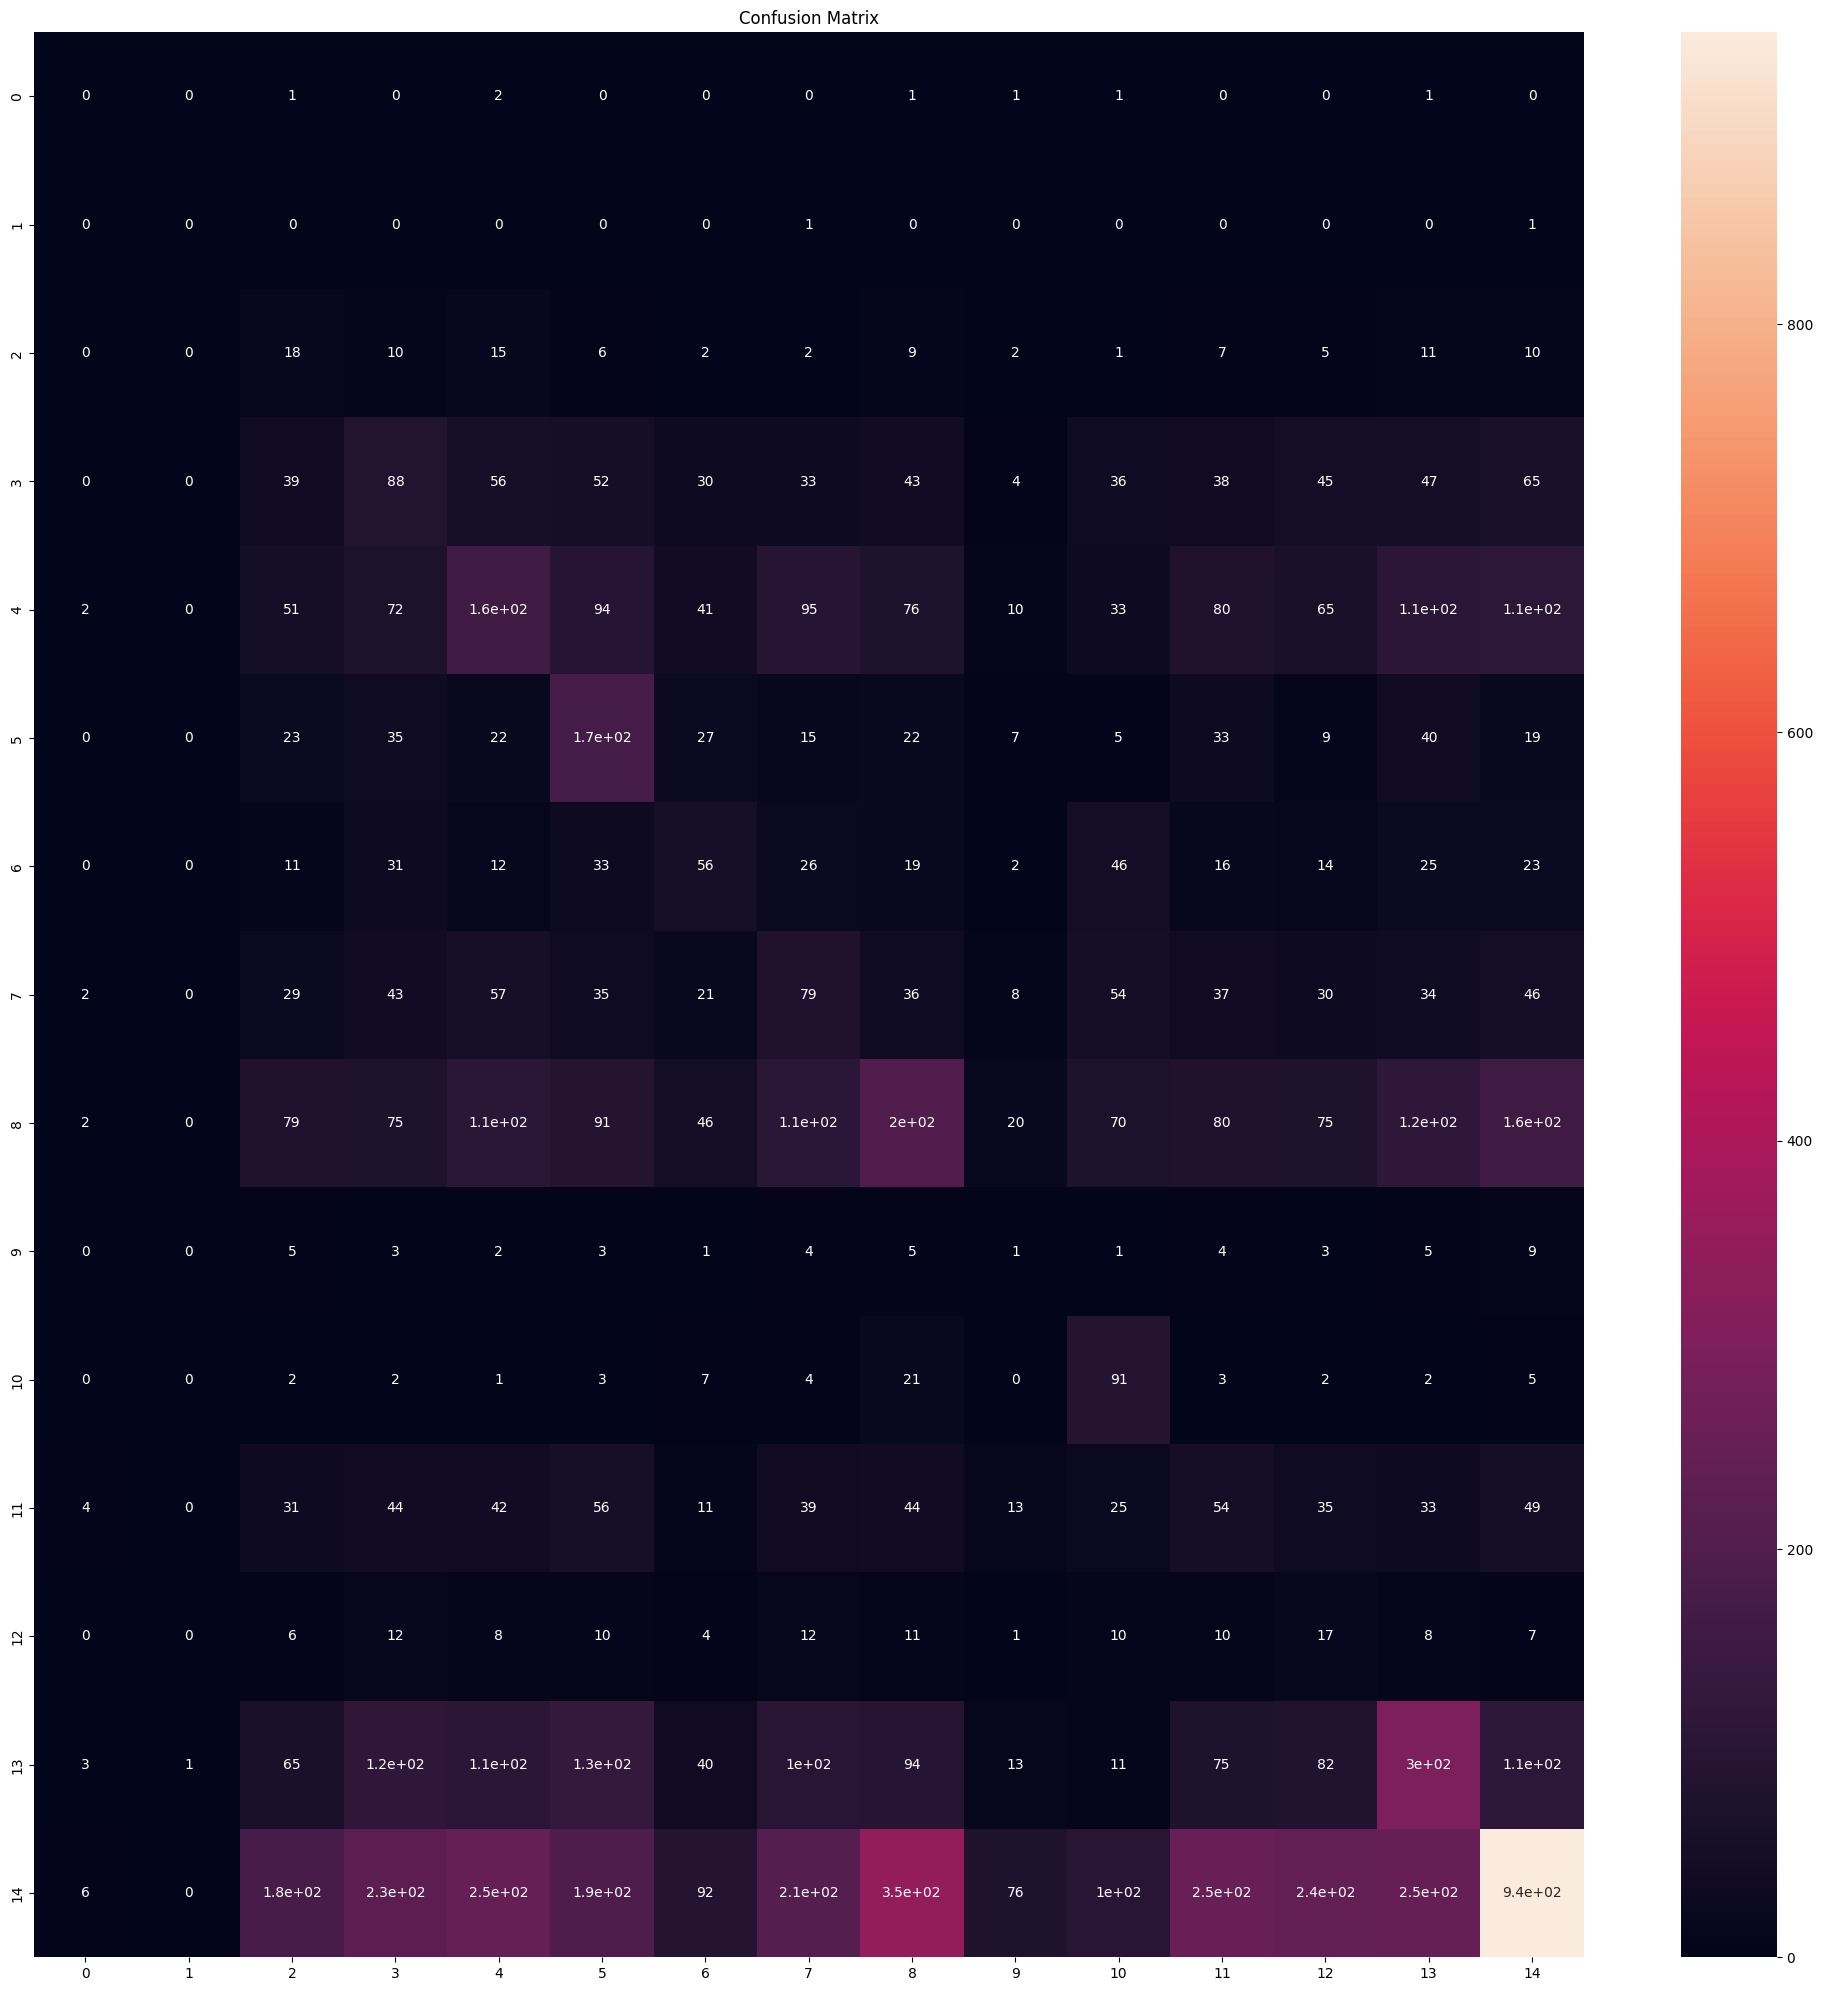

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize = (25,25))
plt.title('Confusion Matrix')

sns.heatmap(confusion_matrix, annot=True)

In [34]:
from sklearn.metrics import f1_score 
f1 = f1_score(test_df['action'], preds, average='micro')
print('F1-score: {0:.4f}'.format(f1))

F1-score: 0.2278
